# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import utm
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import prepostprocessing.cleaning as cleaning
import prepostprocessing.pre_processing as preproc
from plots import plots as plots

In [3]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

## Mineralogy

In [4]:
mineralogy = pd.read_excel("../_CLEANED/Vistelius_data_cleaned.xlsx", index_col=0)

### Check for wrong entries

In [5]:
np.isclose(mineralogy.loc[:, :"oth"].sum(axis=1), mineralogy.loc[:, "sum"])

array([ True,  True,  True, ...,  True,  True,  True])

In [6]:
wrong_sum = mineralogy.loc[~np.isclose(mineralogy.loc[:, :"oth"].sum(axis=1), mineralogy.loc[:, "sum"]), :]

In [7]:
# Check to see if any remaining incorrect lines are present
wrong_sum

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs


In [8]:
mineralogy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659 entries, 1 to 4659
Data columns (total 15 columns):
SiO2     4659 non-null float64
TiO2     4626 non-null float64
Al2O3    4659 non-null float64
Fe2O3    4657 non-null float64
FeO      4659 non-null float64
MnO      4544 non-null float64
MgO      4658 non-null float64
CaO      4659 non-null float64
Na2O     4659 non-null float64
K2O      4659 non-null float64
P2O5     3834 non-null float64
l.i.     4659 non-null float64
oth      874 non-null float64
sum      4659 non-null float64
hs       2240 non-null float64
dtypes: float64(15)
memory usage: 582.4 KB


In [9]:
wrong_sum.loc[:, :"oth"].sum(axis=1)

Series([], dtype: float64)

In [10]:
mineralogy.head()

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1,80.80,0.04,10.16,0.61,1.72,NaN,0.40,0.55,2.00,3.59,NaN,0.35,NaN,100.22,NaN
2,80.00,0.10,10.10,0.17,0.56,0.02,0.40,0.35,2.30,5.10,0.05,0.50,NaN,99.65,NaN
3,79.92,0.05,9.89,0.16,1.73,0.02,0.12,0.14,0.75,6.15,NaN,1.02,0.08,100.03,0.30
4,79.65,0.04,9.64,1.15,0.75,0.10,0.45,0.67,3.71,4.25,NaN,0.26,NaN,100.67,0.01
5,79.18,0.08,10.24,0.64,2.60,0.04,0.05,1.25,1.52,3.08,0.01,1.75,0.16,100.60,0.28


### Cleaning



In [11]:
# Replace zero values
mineralogy = preproc.replace_zero(mineralogy, 0.01)

In [12]:
mineralogy.to_excel("../_CLEANED/Vistelius_data_cleaned.xlsx")

In [13]:
# Also replace NaN values by 0.01
mineralogy = preproc.replace_nan(mineralogy, 0.01)

In [14]:
# Normalize specific columns
mineralogy.loc[:, :"oth"] = preproc.normalize(mineralogy.loc[:, :"oth"])# , total=mineralogy['sum'])

In [15]:
# Renew 'sum' column to reflect changes applied during cleaning
mineralogy["sum"] = mineralogy.loc[:, :"oth"].sum(axis=1)

In [16]:
# Check that sum of all variables + 'sum' == 200
assert all(np.isclose(mineralogy.loc[:, :'sum'].sum(axis=1), 200.0))

In [17]:
mineralogy.to_excel("../_INTERPOLATION/normalised_values.xlsx")

### centred log-ratio (clr) transformation

In [18]:
mineralogy_clr = preproc.clr(mineralogy)
mineralogy_clr.head()

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1,5.116216,-2.494637,3.042697,0.229942,1.266563,-3.880932,-0.192052,0.126402,1.417386,2.002391,-3.880932,-0.325583,-3.880932,5.331906,-3.878435
2,5.027136,-1.657475,2.957645,-1.126847,0.065291,-3.266913,-0.271181,-0.404712,1.478019,2.274350,-2.350623,-0.048037,-3.960060,5.246874,-3.963466
3,4.900117,-2.476641,2.810616,-1.313490,1.067213,-3.392932,-1.601172,-1.447021,0.231409,2.335543,-4.086079,0.538894,-2.006637,5.124661,-0.684482
4,4.911676,-2.684842,2.799955,0.673796,0.246352,-1.768551,-0.264473,0.133557,1.845066,1.980953,-4.071136,-0.813039,-4.071136,5.146081,-4.064260
5,4.525075,-2.372377,2.479653,-0.292936,1.108863,-3.065524,-2.842381,0.376495,0.572062,1.278281,-4.451819,0.712967,-1.679230,4.764504,-1.113632


### Principal Component Analysis (PCA)

In [19]:
mineralogy_pca = preproc.pca(mineralogy_clr)
preproc.pca_variance(mineralogy_pca)

9 PCA components  out of 15 components with variance sum 0.966625886419962 needed for obtaining sum of variance > 0.95


array([2.72769107e-01, 1.98486337e-01, 1.35269270e-01, 1.11034812e-01,
       8.48676592e-02, 5.96963124e-02, 4.62857519e-02, 3.20709944e-02,
       2.61456423e-02, 1.88742451e-02, 1.07280680e-02, 3.03849513e-03,
       7.04237437e-04, 2.90679570e-05, 1.71494552e-32])

In [20]:
mineralogy_pca_df = preproc.create_pca_df(mineralogy_pca, mineralogy_clr)

In [21]:
mineralogy_pca_df

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12,PC13,PC14,PC15
1,0.070870,-1.570739,-0.662051,0.609276,0.342458,-0.268580,-1.071697,0.923562,0.139705,-1.049387,-0.157287,0.386721,0.210287,0.012389,4.991755e-16
2,-0.261688,-1.375756,0.805870,-0.300059,0.759149,-0.675690,-0.451482,0.306834,0.781251,0.542305,-0.157483,0.341606,0.209525,0.039844,2.172231e-16
3,3.914195,-1.572119,0.813464,1.076293,0.784873,-1.234797,0.391221,-0.305773,0.900094,-1.047324,-0.883750,0.863245,0.139512,0.048587,5.252676e-16
4,-0.160643,-1.815379,-1.297618,0.321477,-0.189479,0.327796,0.756335,1.567153,0.233893,0.037679,-0.114667,-0.074479,0.277424,0.028466,-1.286639e-16
5,3.508039,-1.311824,0.204961,1.717288,-0.080573,-1.328450,1.018126,-0.541024,-1.417501,-1.140806,-0.429481,0.342445,0.272092,0.014137,7.446751e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,-0.006406,2.916627,-0.195252,-1.112546,-1.041502,-0.522344,0.727264,0.878206,-0.288274,-0.425628,0.025780,-0.221353,-0.205672,0.066938,-1.660513e-16
4656,-2.943692,2.152769,-0.382931,0.289568,-0.498874,0.052471,-0.014788,0.022861,-0.220074,-0.690008,0.068836,0.207449,-0.131385,0.085468,4.239758e-16
4657,0.390174,3.309386,0.031281,-0.029892,-1.308320,-0.381930,0.393931,0.030935,0.068661,-0.155013,-0.229203,0.029254,-0.115538,0.087171,1.345464e-16
4658,0.424394,3.407414,-0.188329,-0.859408,-0.620405,-1.057895,0.184711,-0.269273,-0.595109,-0.036959,0.622897,-0.002238,-0.274277,0.062982,4.152935e-16


____

## Coordinates

In [22]:
coordinates = pd.read_excel("../_DATA/full_with_coordinates.xlsx", index_col=0, usecols=[0, 1, 2, 3])

In [23]:
coordinates

,Latitude,Longitude,past_mer
1,"44°31'30.0""","138°37'30.0""",NaN
2,"54°12'10.0""","119°24'0.0""",NaN
3,"62°36'0.0""","155°36'0.0""",NaN
4,"61°35'0.0""","146°2'0.0""",NaN
5,"68°55'0.0""","164°24'0.0""",NaN
...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",NaN
4656,"46°56'30.0""","137°5'3.0""",NaN
4657,"58°12'0.0""","138°12'0.0""",NaN
4658,"60°51'0.0""","147°31'0.0""",NaN


In [24]:
# Delete negative signs in "Longitude" column for dms2dec function to work properly
coordinates["Longitude"] = coordinates["Longitude"].str.replace("-", "")

In [25]:
# Include W in "Longitude" column
sum_ = 0

for index, row in coordinates.iterrows():
    if ("W" in str(row["past_mer"])) or ("w" in str(row["past_mer"])):
        coordinates.loc[index, "Longitude"] = row["Longitude"] + "W"
        
        sum_ += 1

In [26]:
# Check that all occurences of "W" or "w" are catched
assert sum_ == int(coordinates["past_mer"].value_counts())

### Convert from degrees to decimal format

In [27]:
coordinates["Y"] = coordinates.loc[:, "Latitude"].apply(cleaning.dms2dec)
coordinates["X"] = coordinates.loc[:, "Longitude"].apply(cleaning.dms2dec)

In [28]:
# Check
coordinates.loc[42, "X"]

149.38333333333333

In [29]:
coordinates

,Latitude,Longitude,past_mer,Y,X
1,"44°31'30.0""","138°37'30.0""",NaN,44.525000,138.625000
2,"54°12'10.0""","119°24'0.0""",NaN,54.202778,119.400000
3,"62°36'0.0""","155°36'0.0""",NaN,62.600000,155.600000
4,"61°35'0.0""","146°2'0.0""",NaN,61.583333,146.033333
5,"68°55'0.0""","164°24'0.0""",NaN,68.916667,164.400000
...,...,...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",NaN,66.700000,164.383333
4656,"46°56'30.0""","137°5'3.0""",NaN,46.941667,137.084167
4657,"58°12'0.0""","138°12'0.0""",NaN,58.200000,138.200000
4658,"60°51'0.0""","147°31'0.0""",NaN,60.850000,147.516667


### adding noise to coordinates

In [30]:
coordinates_noise = pd.read_excel("../_INTERPOLATION/coordinates_decimal.xlsx", index_col=0)

In [31]:
coordinates_noise = coordinates_noise.rename({"Y": "Y_without_noise", "X": "X_without_noise"}, axis=1)

In [32]:
# coordinates_noise["random_value"] = np.random.random(size=len(coordinates_noise))
# coordinates_noise["mean"] = 0
# coordinates_noise["std"] = 0.00007

# You don't seem to use the 'random_value' anywhere so commented it
# Instead of assigning the mean and std to every row it is much faster to define it once
# and then use it when calling the random normal sample.
noise_mean = 0
noise_std = 0.00007

In [33]:
# You can set up your own 'pseudo' random number generator with np.random.RandomState(x)
# where x is the random seed that you can choose, I just chose 4343
# This way the samples from the normal distribution will be random but will be the same every time you
# rerun this cell, so that your results in the second notebook 'Interpolation' will also stay the same
# even after rerunning. Otherwise, at every run of the next cell, numpy will choose a new random seed.
# You may also find online that people say to just set the RandomState with np.random.seed = 4343
# but this will affect every random process you start anywhere and that's not what you want for now
pnrg = np.random.RandomState(4343)

In [34]:
# coordinates_noise["normal_distribution"] =  np.random.normal(noise_mean, noise_std)

# Would sample two random numbers so that the coordinates can change in all direction and not just NE or SW
coordinates_noise["noise_for_X"] =  pnrg.normal(noise_mean, noise_std, size=coordinates_noise.shape[0])
coordinates_noise["noise_for_Y"] =  pnrg.normal(noise_mean, noise_std, size=coordinates_noise.shape[0])

In [35]:
coordinates_noise["Y"] = coordinates_noise["Y_without_noise"] + coordinates_noise["noise_for_X"]
coordinates_noise["X"] = coordinates_noise["X_without_noise"] + coordinates_noise["noise_for_Y"]

In [36]:
# NEW
coordinates_noise

,Latitude,Longitude,past_mer,Y_without_noise,X_without_noise,noise_for_X,noise_for_Y,Y,X
1,"44°31'30.0""","138°37'30.0""",NaN,44.525027,138.625027,0.000058,-0.000078,44.525085,138.624949
2,"54°12'10.0""","119°24'0.0""",NaN,54.202861,119.400083,0.000016,-0.000237,54.202877,119.399847
3,"62°36'0.0""","155°36'0.0""",NaN,62.600001,155.600001,0.000044,-0.000109,62.600044,155.599891
4,"61°35'0.0""","146°2'0.0""",NaN,61.583302,146.033302,0.000132,-0.000076,61.583433,146.033226
5,"68°55'0.0""","164°24'0.0""",NaN,68.916552,164.399886,-0.000019,-0.000077,68.916533,164.399808
...,...,...,...,...,...,...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",NaN,66.699978,164.383312,-0.000118,0.000014,66.699861,164.383326
4656,"46°56'30.0""","137°5'3.0""",NaN,46.941677,137.084177,-0.000016,-0.000020,46.941661,137.084157
4657,"58°12'0.0""","138°12'0.0""",NaN,58.199973,138.199973,-0.000079,-0.000040,58.199894,138.199934
4658,"60°51'0.0""","147°31'0.0""",NaN,60.849992,147.516659,-0.000163,0.000135,60.849829,147.516794


In [37]:
# OLD
coordinates_noise

,Latitude,Longitude,past_mer,Y_without_noise,X_without_noise,noise_for_X,noise_for_Y,Y,X
1,"44°31'30.0""","138°37'30.0""",NaN,44.525027,138.625027,0.000058,-0.000078,44.525085,138.624949
2,"54°12'10.0""","119°24'0.0""",NaN,54.202861,119.400083,0.000016,-0.000237,54.202877,119.399847
3,"62°36'0.0""","155°36'0.0""",NaN,62.600001,155.600001,0.000044,-0.000109,62.600044,155.599891
4,"61°35'0.0""","146°2'0.0""",NaN,61.583302,146.033302,0.000132,-0.000076,61.583433,146.033226
5,"68°55'0.0""","164°24'0.0""",NaN,68.916552,164.399886,-0.000019,-0.000077,68.916533,164.399808
...,...,...,...,...,...,...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",NaN,66.699978,164.383312,-0.000118,0.000014,66.699861,164.383326
4656,"46°56'30.0""","137°5'3.0""",NaN,46.941677,137.084177,-0.000016,-0.000020,46.941661,137.084157
4657,"58°12'0.0""","138°12'0.0""",NaN,58.199973,138.199973,-0.000079,-0.000040,58.199894,138.199934
4658,"60°51'0.0""","147°31'0.0""",NaN,60.849992,147.516659,-0.000163,0.000135,60.849829,147.516794


In [38]:
coordinates_noise.to_excel("../_DATA/full_with_coordinates_noice_final_new.xlsx")

In [39]:
coordinates = pd.read_excel("../_DATA/full_with_coordinates_noice_final.xlsx", index_col=0, usecols=[0, 1, 2, 3, 10, 11])

In [40]:
coordinates

,Latitude,Longitude,past_mer,Y,X
1,"44°31'30.0""","138°37'30.0""",NaN,44.525040,138.625040
2,"54°12'10.0""","119°24'0.0""",NaN,54.202798,119.400020
3,"62°36'0.0""","155°36'0.0""",NaN,62.599978,155.599978
4,"61°35'0.0""","146°2'0.0""",NaN,61.583249,146.033249
5,"68°55'0.0""","164°24'0.0""",NaN,68.916572,164.399905
...,...,...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",NaN,66.699992,164.383326
4656,"46°56'30.0""","137°5'3.0""",NaN,46.941584,137.084084
4657,"58°12'0.0""","138°12'0.0""",NaN,58.200076,138.200076
4658,"60°51'0.0""","147°31'0.0""",NaN,60.849958,147.516625


### Convert to UTM coordinates

In [41]:
coordinates_utm = coordinates.apply(lambda row : utm.from_latlon(row["Y"], row["X"], force_zone_number=48, force_zone_letter="U"), axis=1)
coordinates_utm = coordinates_utm.apply(pd.Series)
coordinates_utm.columns = ["Y_UTM", "X_UTM", "ZoneNumber", "ZoneLetter"]

In [42]:
coordinates_utm

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
1,3.166850e+06,5.512837e+06,48,U
2,1.436111e+06,6.102354e+06,48,U
3,2.874853e+06,7.966637e+06,48,U
4,2.565651e+06,7.521202e+06,48,U
5,2.540731e+06,8.757731e+06,48,U
...,...,...,...,...
4655,2.759727e+06,8.616851e+06,48,U
4656,2.927123e+06,5.721711e+06,48,U
4657,2.397980e+06,6.939549e+06,48,U
4658,2.684981e+06,7.505261e+06,48,U


In [43]:
coordinates_utm["ZoneNumber"].value_counts()

48    4659
Name: ZoneNumber, dtype: int64

In [44]:
coordinates_utm["ZoneLetter"].value_counts()

U    4659
Name: ZoneLetter, dtype: int64

In [45]:
(coordinates_utm["ZoneNumber"].astype(str) + coordinates_utm["ZoneLetter"]).value_counts()

48U    4659
dtype: int64

In [46]:
coordinates_utm.to_excel("../_INTERPOLATION/coordinates_UTM.xlsx")
cof= pd.read_excel("../_RESULTS/working_data.xlsx", index_col=0, usecols = lambda column : column not in ["Lat_deg", "Lat_min", "Lat_sec", "Long_deg", "Long_min", "Long_sec", "past_mer"] )

In [47]:
cof

,type_granite,time,massif,sampler,others,sampler+year
512,Granite coarse-grained,Tr-J,Yugalkan massif,T.A.Alfer'eva,NaN,"A.D.Kanischev,1959"
1299,Granite coarse-grained,Tr-J,NaN,G.L.Znamenskaya,NaN,"N.P.Kostyakov,1961"
1536,Bt granite porphyraceous,Tr-J,NaN,E.G.Ivanova,NaN,"L.A.Kozubova,1957"
1760,Bt granite medium-grained,Tr-J,NaN,NaN,NaN,"V.I.Fel'dman,1956"
1890,Plagiogranite,Tr-J,NaN,NI.Serebryakova,NaN,"A.V.Vnukov,1959"
...,...,...,...,...,...,...
1150,Granite leucocratic,J,Upper-Buy massif,NaN,.N.P.Mel'nikova,"V.V.Starchenko,1968"
1396,Granite,Tr,Ust'-Nerchugan massifmassif,N.Aolebedeva,NaN,"K.F.Khatskevich,1967"
2116,Granite,NaN,NaN,N.I.Serebryakov~,NaN,"V.Yu.Shenfil,1962"
2973,Bt granite-porphyry,NaN,Ergelyakh massif,G.P.Ignatovich,NaN,"G.G.Naumov,1978"


In [97]:
CIPW = pd.read_excel("../_CIPW/CIPW/1_normalized_QAPF_plot.xlsx", index_col=0, usecols=[0, 3])

In [154]:
classification_renaming_dict = {"quartz monzodiorite\nquartz monzogabbro" : "quartz monzodiorite\quartz monzogabbro",
                                "quartz diorite\nquartz gabbro\nquartz anorthosite" : "quartz diorite\quartz gabbro\quartz anorthosite"}

In [155]:
CIPW['QAPF'] = CIPW['QAPF'].replace(classification_renaming_dict)

In [156]:
coordinates_full = pd.concat([coordinates_utm, coordinates, mineralogy, cof, CIPW], axis = 1)

In [157]:
coordinates_full.to_excel("../_INTERPOLATION/coordinates_full_data.xlsx")


### Grouping of the data

In [158]:
areax = coordinates_full
areax["area"] = ""

In [159]:
areay1 = areax[areax["X"].between(107.20, 121)]
area1 = areay1[areay1["Y"].between(48.85, 56.6)]
area1["area"] = 1
area1.to_excel("../_INTERPOLATION/area1.xlsx")

C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [160]:
areay2 = areax[areax["X"].between(131.75, 141.5)]
area2 = areay2[areay2["Y"].between(42, 56)]
area2["area"] = 2
area2.to_excel("../_INTERPOLATION/area2.xlsx")


C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [161]:
areay3 = areax[areax["X"].between(133, 160.5)]
area3 = areay3[areay3["Y"].between(58.6, 70.85)]
area3["area"] = 3
area3.to_excel("../_INTERPOLATION/area3.xlsx")

C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [162]:
areay4 = areax[areax["X"].between(160.5, 180)]
area4 = areay4[areay4["Y"].between(60.75, 70.25)]
area4["area"] = 4
area4.to_excel("../_INTERPOLATION/area4.xlsx")

C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [163]:
areay5 = areax[areax["X"].between(-180, -165)]
area5 = areay5[areay5["Y"].between(63, 70)]
area5["area"] = 5
area5.to_excel("../_INTERPOLATION/area5.xlsx")

In [164]:
area12 = area1.append(area2)
area123 = area12.append(area3) 
area1234 = area123.append(area4) 
area = area1234.append(area5) 
area.to_excel("../_INTERPOLATION/area_subdivided.xlsx")

____

## Metadata

In [179]:
metadata = pd.read_excel("../_INTERPOLATION/coordinates_full_data.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30, 31])

In [180]:
metadata

,type_granite,time,massif,sampler,others,sampler+year,QAPF
1,Granite leucogranitic,K,NaN,NaN,NaN,"V.N.Musin,1970",monzo granite
2,Granite leucocratic,Tr,NaN,V.I.Zhigalova,NaN,"E.A.Ivanov,1969",monzo granite
3,Granite leucocratic coarse-grained,K,Omsukchan massif,P.M.Bosek,NaN,"O.S.Gracheva,1948",syeno granite
4,Granite leucocratic,K,Buksandzhin massif,A.Kh.Brovtman,NaN,"A.F.Mikhaylov,1948",monzo granite
5,Granite-porphyry micropegmatitic,K,Attykveem massif,L.G.Semenova,0th.:S-0.16,"A.I.Sadovsky,1963",monzo granite
...,...,...,...,...,...,...,...
4655,Diorite,K,Egdegkych massif,NaN,Oth.:co2-0.12,"V.A.lgnat'ev,1964",monzodiorite monzogabbro
4656,Quartz diorite,K,Verkhneplotnikovsky massif,NaN,NaN,"A.A.Syas'ko,1969",monzodiorite monzogabbro
4657,Diorite,J,NaN,NaN,"Oth.:co2-0.02,so3-0.0l","N.N.Remizov,1967",monzodiorite monzogabbro
4658,Diorite,K,NaN,NaN,NaN,"A.P.Osipov,1966",monzodiorite monzogabbro


In [181]:
metadata["type_granite"].value_counts()

Granite                                  656
Granodiorite                             523
Granite-porphyry                         282
Bt granite                               268
Granite leucocratic                      220
                                        ... 
Hb-Bt plagiogranite                        1
Aplite leucocratic                         1
Amf-Bt granite porphyraceous               1
granite                                    1
Granite leucogranitoid medium-grained      1
Name: type_granite, Length: 401, dtype: int64

In [182]:
metadata["massif"].value_counts()

Ulakhan-Sis massif               58
Khoboyotuu-Echiy massif          56
Vladimirsky massif               35
Zimov'e massif                   33
Bom-Gorkhon massif               31
                                 ..
Nakhodka stock                    1
An-May massif                     1
Upper-Lel vergyrgyn intrusion     1
Upper-Tala massif                 1
Khas-Yuryakh massif               1
Name: massif, Length: 941, dtype: int64

In [183]:
metadata["time"].value_counts()

K       2522
J        825
Tr       517
Pg       365
Tr-J     338
Mz        88
Name: time, dtype: int64

In [184]:
metadata["sampler"].value_counts()

L.S.Voronova         120
D.M.Shuster           87
N.A.Lebedeva          86
V.I.Zhigalova         70
N.P.Mel'nikova        51
                    ... 
L.I.Knyazeva           1
N.O.Tikhon'kikh        1
I.A.Stolyarov          1
A.V.Mashin istova      1
S.M,Shadskaya          1
Name: sampler, Length: 736, dtype: int64

In [185]:
metadata["sampler+year"].value_counts()

G.A.Valuy,1975         76
V.A.Popeko,1968        61
V.A.Faradzhev,1971     43
V.S.Ivanov,1968        37
R.O.Galabala,1976      37
                       ..
V.G.Korol'kov,1966      1
l.A.Gaev,1960           1
Z.A.Pavlova,1954        1
G.Ya.Makarenko,1947     1
E.O.Kas'yan,1970        1
Name: sampler+year, Length: 1392, dtype: int64

In [186]:
metadata["QAPF"].value_counts()

monzo granite                                      3298
granodiorite                                        673
quartz monzodiorite\quartz monzogabbro              341
quartz monzonite                                    252
syeno granite                                        36
monzodiorite monzogabbro                             28
tonalite                                             12
monzonite                                             8
quartz-rich granitoid                                 5
quartz diorite\quartz gabbro\quartz anorthosite       4
quartz syenite                                        1
diorite gabbro anorthosite                            1
Name: QAPF, dtype: int64

## data for each area

In [187]:
metadata_area1 = pd.read_excel("../_INTERPOLATION/area1.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30,31])
metadata_area2 = pd.read_excel("../_INTERPOLATION/area2.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30,31])
metadata_area3 = pd.read_excel("../_INTERPOLATION/area3.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30,31])
metadata_area4 = pd.read_excel("../_INTERPOLATION/area4.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30,31])
metadata_area5 = pd.read_excel("../_INTERPOLATION/area5.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30,31])


In [188]:
coordinates_utm_area1 = pd.read_excel("../_INTERPOLATION/area1.xlsx", index_col=0, usecols=[0, 1, 2, 3, 4])
coordinates_utm_area2 = pd.read_excel("../_INTERPOLATION/area2.xlsx", index_col=0, usecols=[0, 1, 2, 3, 4])
coordinates_utm_area3 = pd.read_excel("../_INTERPOLATION/area3.xlsx", index_col=0, usecols=[0, 1, 2, 3, 4])
coordinates_utm_area4 = pd.read_excel("../_INTERPOLATION/area4.xlsx", index_col=0, usecols=[0, 1, 2, 3, 4])
coordinates_utm_area5 = pd.read_excel("../_INTERPOLATION/area5.xlsx", index_col=0, usecols=[0, 1, 2, 3, 4])

In [189]:
coordinates_area1 = pd.read_excel("../_INTERPOLATION/area1.xlsx", index_col=0, usecols=[0, 5, 6, 7, 8, 9])
coordinates_area2 = pd.read_excel("../_INTERPOLATION/area2.xlsx", index_col=0, usecols=[0, 5, 6, 7, 8, 9])
coordinates_area3 = pd.read_excel("../_INTERPOLATION/area3.xlsx", index_col=0, usecols=[0, 5, 6, 7, 8, 9])
coordinates_area4 = pd.read_excel("../_INTERPOLATION/area4.xlsx", index_col=0, usecols=[0, 5, 6, 7, 8, 9])
coordinates_area5 = pd.read_excel("../_INTERPOLATION/area5.xlsx", index_col=0, usecols=[0, 5, 6, 7, 8, 9])

In [190]:
mineralogy_area1 = pd.read_excel("../_INTERPOLATION/area1.xlsx", index_col=0, usecols=[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
mineralogy_area2 = pd.read_excel("../_INTERPOLATION/area2.xlsx", index_col=0, usecols=[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
mineralogy_area3 = pd.read_excel("../_INTERPOLATION/area3.xlsx", index_col=0, usecols=[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
mineralogy_area4 = pd.read_excel("../_INTERPOLATION/area4.xlsx", index_col=0, usecols=[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
mineralogy_area5 = pd.read_excel("../_INTERPOLATION/area5.xlsx", index_col=0, usecols=[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

In [191]:
mineralogy_clr_area1 = preproc.clr(mineralogy_area1)
mineralogy_clr_area2 = preproc.clr(mineralogy_area2)
mineralogy_clr_area3 = preproc.clr(mineralogy_area3)
mineralogy_clr_area4 = preproc.clr(mineralogy_area4)
mineralogy_clr_area5 = preproc.clr(mineralogy_area5)

In [192]:
mineralogy_pca_area1 = preproc.pca(mineralogy_clr_area1)
preproc.pca_variance(mineralogy_pca_area1)

mineralogy_pca_area2 = preproc.pca(mineralogy_clr_area2)
preproc.pca_variance(mineralogy_pca_area2)

mineralogy_pca_area3 = preproc.pca(mineralogy_clr_area3)
preproc.pca_variance(mineralogy_pca_area3)

mineralogy_pca_area4 = preproc.pca(mineralogy_clr_area4)
preproc.pca_variance(mineralogy_pca_area4)

mineralogy_pca_area5 = preproc.pca(mineralogy_clr_area5)
preproc.pca_variance(mineralogy_pca_area5)

8 PCA components  out of 13 components with variance sum 0.9555579066346551 needed for obtaining sum of variance > 0.95
8 PCA components  out of 13 components with variance sum 0.9593403254547035 needed for obtaining sum of variance > 0.95
8 PCA components  out of 13 components with variance sum 0.9627406809523947 needed for obtaining sum of variance > 0.95
8 PCA components  out of 13 components with variance sum 0.9602804485255654 needed for obtaining sum of variance > 0.95
7 PCA components  out of 13 components with variance sum 0.96013561671489 needed for obtaining sum of variance > 0.95


array([3.26599017e-01, 2.13750993e-01, 1.57958438e-01, 1.02940256e-01,
       7.36900126e-02, 5.32433330e-02, 3.19535673e-02, 1.74469492e-02,
       1.30907170e-02, 7.53890350e-03, 1.25766416e-03, 5.30149449e-04,
       2.74294555e-32])

In [193]:
mineralogy_pca_area1_df = preproc.create_pca_df(mineralogy_pca_area1, mineralogy_clr_area1)
mineralogy_pca_area2_df = preproc.create_pca_df(mineralogy_pca_area2, mineralogy_clr_area2)
mineralogy_pca_area3_df = preproc.create_pca_df(mineralogy_pca_area3, mineralogy_clr_area3)
mineralogy_pca_area4_df = preproc.create_pca_df(mineralogy_pca_area4, mineralogy_clr_area4)
mineralogy_pca_area5_df = preproc.create_pca_df(mineralogy_pca_area5, mineralogy_clr_area5)

In [194]:
mineralogy_all_areas = {
    "area1": mineralogy_area1,
    "area2": mineralogy_area2,
    "area3": mineralogy_area3,
    "area4": mineralogy_area4,
    "area5": mineralogy_area5,
}

In [195]:
mineralogy_pca_all_areas = {
    "area1": mineralogy_pca_area1,
    "area2": mineralogy_pca_area2,
    "area3": mineralogy_pca_area3,
    "area4": mineralogy_pca_area4,
    "area5": mineralogy_pca_area5,
}

In [196]:
mineralogy_pca_df_all_areas = {
    "area1": mineralogy_pca_area1_df,
    "area2": mineralogy_pca_area2_df,
    "area3": mineralogy_pca_area3_df,
    "area4": mineralogy_pca_area4_df,
    "area5": mineralogy_pca_area5_df,
}

In [197]:
metadata_all_areas = {
    "area1": metadata_area1,
    "area2": metadata_area2,
    "area3": metadata_area3,
    "area4": metadata_area4,
    "area5": metadata_area5,
}

## CPV plots

**You can now also quickly query the number of PCs needed for reaching a different threshold value than 0.95. See example below.**

**remark**
1) I made an excel file called "error budget" to see the number of PC's needed. Did it first for the MSPE, but also for the Var(OK) from the excel file you send during the meeting. It seems tha we have to use the variance instead of the gain in MSPE. But the variances do differ greatly with the ones below. what is the difference between both variances? (the one used here and the ones in the error budget)  
**The variances used here are related to the PCA model and sum up to one (because they represent ratios; 'explained_variance_ratio_' method of PCA class of scitkit-learn).   
The VAR(OK) is the variance of the interpolated data (of the grid) and can thus be seen as how much variance is captured by the interpolation itself. 
The MSPE (Mean Squared Prediction Error) is a result from the cross validation that was performed and is thus a direct measure of how well the interpolation performed. That's why we use this measure in the error budget to further determine how many PCs are useful to use in the actual interpolation. In other words, which model (with certain number of PCs) is the best interpolation model.**

**Workflow-wise, the CPV can be used as first estimate to see how many PCs carry signal (as opposed to noise) data-wise. If this wasn't also a spatial problem that we are dealing with, we could stop there. But since we are trying to interpolation said data in space, we also want to know what the spatial signal is that the PCs carry. This is why we look at the MSPE to further finetune the number of PCs we need.  
In a sense the VAR(OK) can also tell you something about this latter part, since the MSPE stems form cross validation and the VAR(OK) is the result from one selected model the MSPE should be a much more robust parameter to use for this purpose.**  

**Hopefully that answers your question, but it is certainly a valid point to bring up the use of the VAR(OK).**

2) why is the value of 0.80 used in preproc.pca_variance(mineralogy_pca_area1, 0.80), is it an arbitrary number because 0.95 of 0.86187 ~ 0.8?  
**0.8 is just an arbitrary number, I just included this to show that you can also use a different threshold value than 0.95, although the latter is most commonly used.**

In [75]:
preproc.pca_variance(mineralogy_pca_area1, 0.80)

6 PCA components  out of 13 components with variance sum 0.8618712489921863 needed for obtaining sum of variance > 0.8


array([2.96355019e-01, 1.85954192e-01, 1.38270700e-01, 1.12139084e-01,
       6.66935380e-02, 6.24587158e-02, 4.95929980e-02, 4.40936596e-02,
       2.94532110e-02, 1.04798880e-02, 3.36316913e-03, 1.14582524e-03,
       2.32978932e-32])

In [76]:
pca_expl_var_areas = {}
for i in range(1, 6):
    area = f"area{i}"
    pca_expl_var_areas[area] = mineralogy_pca_all_areas[area].explained_variance_ratio_

In [77]:
n_columns = mineralogy_pca_area1.n_components_
n_columns

13

In [78]:
pca_expl_var_areas_df = pd.DataFrame.from_dict(pca_expl_var_areas, orient='index', columns=range(1, n_columns+1))
pca_expl_var_areas_df[0] = 0
pca_expl_var_areas_df = pca_expl_var_areas_df.T
pca_expl_var_areas_df = pca_expl_var_areas_df.sort_index()
pca_expl_var_areas_df

,area1,area2,area3,area4,area5
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2.963550e-01,2.956598e-01,2.750054e-01,3.350177e-01,3.265990e-01
2,1.859542e-01,2.108269e-01,2.063599e-01,1.984482e-01,2.137510e-01
3,1.382707e-01,1.406402e-01,1.712550e-01,1.544402e-01,1.579584e-01
4,1.121391e-01,1.044730e-01,1.189803e-01,9.258096e-02,1.029403e-01
5,6.669354e-02,7.465263e-02,7.621564e-02,6.513163e-02,7.369001e-02
6,6.245872e-02,4.882889e-02,5.363762e-02,5.581088e-02,5.324333e-02
7,4.959300e-02,4.368001e-02,3.357886e-02,3.459027e-02,3.195357e-02
8,4.409366e-02,4.057885e-02,2.770798e-02,2.426057e-02,1.744695e-02
9,2.945321e-02,2.544689e-02,2.355634e-02,1.842339e-02,1.309072e-02


In [79]:
pca_expl_var_areas_df_cumulative_sum = np.cumsum(pca_expl_var_areas_df)

In [80]:
pca_expl_var_areas_df_cumulative_sum

,area1,area2,area3,area4,area5
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.296355,0.295660,0.275005,0.335018,0.326599
2,0.482309,0.506487,0.481365,0.533466,0.540350
3,0.620580,0.647127,0.652620,0.687906,0.698308
4,0.732719,0.751600,0.771601,0.780487,0.801249
5,0.799413,0.826253,0.847816,0.845619,0.874939
6,0.861871,0.875081,0.901454,0.901430,0.928182
7,0.911464,0.918761,0.935033,0.936020,0.960136
8,0.955558,0.959340,0.962741,0.960280,0.977583
9,0.985011,0.984787,0.986297,0.978704,0.990673


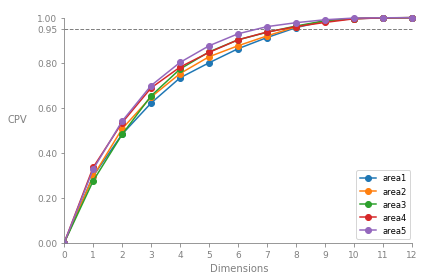

In [81]:
p = pca_expl_var_areas_df_cumulative_sum.iloc[:-1, :].plot(marker="o", alpha=1)
#plt.axhline(0.95, c="k", alpha=0.5)

plt.xlabel("Dimensions", c='grey')
plt.ylabel(r"CPV", c='grey', rotation=0, labelpad=20)
plt.ylim((0, 1.05))

# Change display of spines
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)

# Set the color of the visible spines
p.spines['left'].set_color('grey')
p.spines['bottom'].set_color('grey')

# Set the bounds of the spines
p.set_xlim(0, n_columns-0.9)
p.set_ylim(0, 1.05)

# Set axes ticks
p.set_xticks([x for x in range(n_columns)])
p.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0])

p.spines['bottom'].set_bounds(0.0, n_columns-1)
p.spines['left'].set_bounds(0.0, 1.0)

# Set general tick parameters
p.tick_params(axis='both',
              direction='out',
              colors='grey',
              labelsize=9)

plt.hlines(0.95, 0, n_columns-1, color='grey', linewidth=1, linestyle="--")

plt.gcf().set_facecolor('white')

# plt.margins(1)
plt.tight_layout()

plt.legend(loc="lower right", frameon=True, fontsize='small')

plt.savefig("../_FIGURES/cpv/cpv_all_areas.pdf")
plt.show();

## Biplots

### General outline biplots

**remark**
- What does still have to be done for the biplots? Because these ones seems complete. I still have to highlight the datapoints where zeros where replaced, but what are the other things I should do/taken into account? 

**They are complete for their purpose, indeed. But you could still look at a lot of things! :)**  
**Highlighting the zeros is one thing, incorporating the QAPF classification or cluster analysis classification as color coding is another e.g.**  
**The highlighting of zeros will probably make clear that P2O5, l.i. and oth. should better be combined in one category (you don't need to exclude them entirely).**  
**Already now, their loadings (that's the arrows) are often quite distinct + they often have small concentrations (if any) which made me suggest this in the first place. Nevertheless a visual check with the highlighting should prove helpful here.**

- Is it a good idea to discard the clas of OTH.? because there are a lot of zero values in this class and oth can stand for a lot of minerals. But maybe we alter the data by discarding the oth. class? 

**As explained above, no need to discard it, merely combine it with l.i. and/or P2O5 e.g.** 

In [129]:
# Concatenate pc scores with metadata for plotting of biplot
mineralogy_pca_metadata_all_areas = {}

for area, metadata in metadata_all_areas.items():
    mineralogy_pca_metadata_all_areas[area] = pd.concat([mineralogy_pca_df_all_areas[area], metadata], axis=1)

In [130]:
color_dict = {
    "Tr": sns.color_palette()[0],
    "Tr-J": sns.color_palette()[1],
     "J": sns.color_palette()[2],
     "K": sns.color_palette()[3],
     "Pg": sns.color_palette()[4],
     "Mz": sns.color_palette()[5],
}

In [131]:
hue_orders = {
    "area1": ["Tr", "Tr-J", "J", "K", "Mz"],
    "area2": ["Tr", "J", "K", "Pg"],
    "area3": ["Tr", "J", "K", "Pg"],
    "area4": ["J", "K", "Pg", "Mz"],
    "area5": ["K", "Pg", "Mz"],
}

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


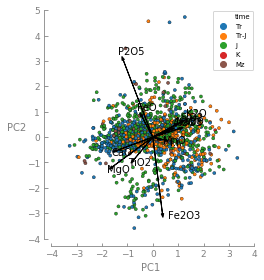

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


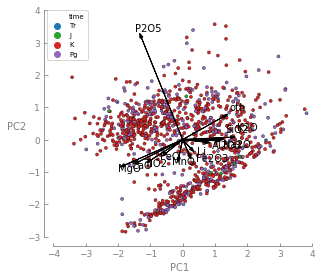

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


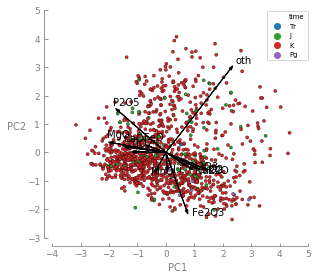

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]


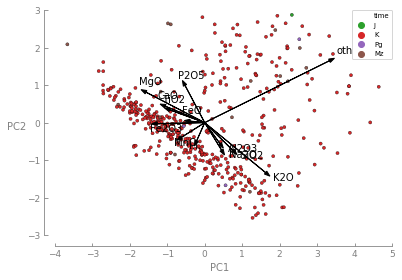

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


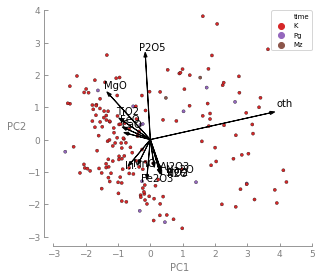

Wall time: 2.25 s


In [142]:
%%time
for area, pca in mineralogy_pca_all_areas.items():
    plots.biplot(pca, 
                 mineralogy_pca_metadata_all_areas[area], 
                 columns=mineralogy_all_areas[area].columns, 
                 group=area,
                 plot_datalabels=False,
                 adjust='box',
                 axes_offset=0.3,
                 loading_factor=1,
                 loadings_forward=True,
                 hue="time",
                 hue_order=hue_orders[area],
                 palette=color_dict,
                 s=10)

### Biplots QAPF

In [218]:
mineralogy_pca_metadata_all_areas = {}

for area, metadata in metadata_all_areas.items():
    mineralogy_pca_metadata_all_areas[area] = pd.concat([mineralogy_pca_df_all_areas[area], metadata], axis=1)

In [219]:
metadata_area1["QAPF"].value_counts()

monzo granite                             1155
quartz monzonite                           115
granodiorite                               109
quartz monzodiorite\quartz monzogabbro      61
syeno granite                               14
monzodiorite monzogabbro                     3
monzonite                                    1
quartz-rich granitoid                        1
Name: QAPF, dtype: int64

In [220]:
metadata_area2["QAPF"].value_counts()

monzo granite                                      698
granodiorite                                       181
quartz monzodiorite\quartz monzogabbro              92
quartz monzonite                                    45
syeno granite                                        9
monzodiorite monzogabbro                             9
monzonite                                            2
quartz diorite\quartz gabbro\quartz anorthosite      1
quartz-rich granitoid                                1
tonalite                                             1
Name: QAPF, dtype: int64

In [221]:
metadata_area3["QAPF"].value_counts()

monzo granite                                      765
granodiorite                                       183
quartz monzodiorite\quartz monzogabbro              94
quartz monzonite                                    51
monzodiorite monzogabbro                             7
syeno granite                                        4
quartz-rich granitoid                                2
tonalite                                             2
quartz diorite\quartz gabbro\quartz anorthosite      1
monzonite                                            1
Name: QAPF, dtype: int64

In [222]:
metadata_area4["QAPF"].value_counts()

monzo granite                                      241
granodiorite                                       130
quartz monzodiorite\quartz monzogabbro              52
quartz monzonite                                    22
tonalite                                             9
syeno granite                                        5
monzodiorite monzogabbro                             4
quartz diorite\quartz gabbro\quartz anorthosite      2
diorite gabbro anorthosite                           1
Name: QAPF, dtype: int64

In [223]:
metadata_area5["QAPF"].value_counts()

monzo granite                             146
granodiorite                               12
quartz monzonite                           10
quartz monzodiorite\quartz monzogabbro      7
monzonite                                   2
monzodiorite monzogabbro                    2
Name: QAPF, dtype: int64

In [224]:
color_dict2 = {
    "monzo granite": sns.color_palette()[0],
     "granodiorite": sns.color_palette()[1],
     "quartz monzodiorite\quartz monzogabbro": sns.color_palette()[2],
     "quartz monzonite": sns.color_palette()[3],
     "syeno granite": sns.color_palette()[4],
     "monzodiorite monzogabbro": sns.color_palette()[5],
     "tonalite": sns.color_palette()[6],
     "monzonite": sns.color_palette()[7],
     "quartz-rich granitoid": sns.color_palette()[8],
     "quartz diorite\quartz gabbro\quartz anorthosite": sns.color_palette()[9],
     "diorite gabbro anorthosite": sns.color_palette()[8],
}

In [225]:
hue_orders2 = {
    "area1": ["monzo granite", "granodiorite", "quartz monzodiorite\quartz monzogabbro", "quartz monzonite", "syeno granite", "monzodiorite monzogabbro", "monzonite", "quartz-rich granitoid"],
    "area2": ["monzo granite", "granodiorite", "quartz monzodiorite\quartz monzogabbro", "quartz monzonite", "syeno granite", "monzodiorite monzogabbro", "tonalite", "monzonite", "quartz-rich granitoid", "quartz diorite\quartz gabbro\quartz anorthosite"],
    "area3": ["monzo granite", "granodiorite", "quartz monzodiorite\quartz monzogabbro", "quartz monzonite", "syeno granite", "monzodiorite monzogabbro", "tonalite", "monzonite", "quartz-rich granitoid", "quartz diorite\quartz gabbro\quartz anorthosite"],
    "area4": ["monzo granite", "granodiorite", "quartz monzodiorite\quartz monzogabbro", "quartz monzonite", "syeno granite", "monzodiorite monzogabbro", "tonalite", "quartz diorite\quartz gabbro\quartz anorthosite", "diorite gabbro anorthosite"],
    "area5": ["monzo granite", "granodiorite", "quartz monzodiorite\quartz monzogabbro", "quartz monzonite", "monzodiorite monzogabbro", "monzonite"],
}

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


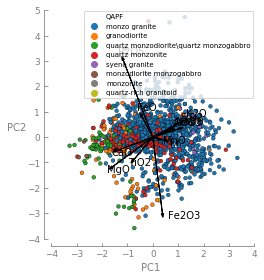

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


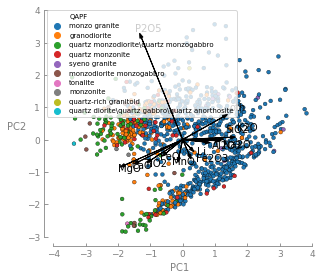

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


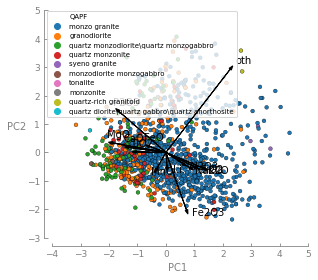

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]


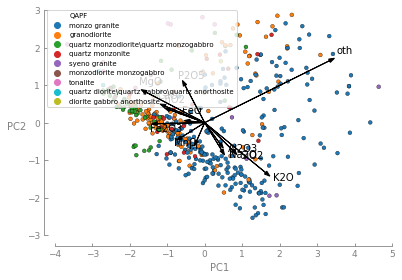

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


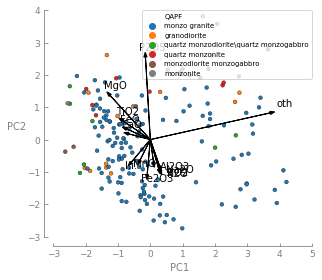

Wall time: 2.8 s


In [226]:
%%time
for area, pca in mineralogy_pca_all_areas.items():
    plots.biplot(pca, 
                 mineralogy_pca_metadata_all_areas[area], 
                 columns=mineralogy_all_areas[area].columns, 
                 group=area,
                 plot_datalabels=False,
                 adjust='box',
                 axes_offset=0.3,
                 loading_factor=1,
                 loadings_forward=True,
                 hue="QAPF",
                 hue_order=hue_orders2[area],
                 palette=color_dict2,
                 s=15)

## Saving of data

In [86]:
# Save data as pickle files to use them in later notebooks
preproc.save_obj(mineralogy_area1, "mineralogy_area1") # mineralogy
preproc.save_obj(mineralogy_clr_area1, "mineralogy_clr_area1") # mineralogy clr
preproc.save_obj(mineralogy_pca_area1, "mineralogy_pca_area1") # mineralogy pca info
preproc.save_obj(mineralogy_pca_area1_df, "mineralogy_pca_area1_df") # mineralogy pca scores

preproc.save_obj(coordinates_area1, "coordinates_area1") # coordinates latlon
preproc.save_obj(coordinates_utm_area1, "coordinates_utm_area1") # coordinates utm
preproc.save_obj(metadata_area1, "metadata_area1") # metadata

____

In [87]:
coordinates_utm_area1

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
2,1.436111e+06,6.102354e+06,48,U
6,1.113927e+06,5.652652e+06,48,U
9,1.068636e+06,5.598845e+06,48,U
10,1.098840e+06,5.690263e+06,48,U
11,9.048985e+05,5.630297e+06,48,U
...,...,...,...,...
4538,1.304961e+06,5.902228e+06,48,U
4552,1.328849e+06,6.028456e+06,48,U
4574,1.413275e+06,6.019949e+06,48,U
4585,1.455811e+06,5.990438e+06,48,U
